# Dự báo "time series"

Giới thiệu về dự báo "chuỗi thời gian" bằng TensorFlow. Nó xây dựng một số kiểu mô hình khác nhau bao gồm Mạng thần kinh chuyển đổi và mạng tái tạo (CNN và RNN).

Gồm 2 phần chính: 

* Dự báo một bước:
  * Một tính năng.
  * Tất cả tính năng.
* Dự báo nhiều bước:
  * Một lần chụp: Đưa ra tất cả dự đoán cùng lúc.
  * Tự hồi quy: Đưa những dự đoán (đầu ra) trở lại mô hình (đầu vào).

## Khai báo thư viện

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing

from google.colab import drive

drive.mount('/content/drive')
mpl.rcParams['figure.figsize'] = (16, 12)
mpl.rcParams['axes.grid'] = False

## Bộ dữ liệu thời tiết

Sử dụng bộ dữ liệu tại trang <a href="https://www.visualcrossing.com/weather/weather-data-services">**Visual crossing**</a>.

Bộ dữ liệu bao gồm 14 đặc trưng bao gồm: nhiệt độ, áp suất khí quyển, độ ẩm,... Được thu nhập mỗi tiếng từ 01/01/2020 đến 22/08/2022

In [ ]:
csv_path = 'drive/MyDrive/Internship/RNN/Data.csv'

In [ ]:
df = pd.read_csv(csv_path)
date_time = pd.to_datetime(df.pop('NgayGio'), format='%Y-%m-%d %H:%M:%S')

Biểu đồ của ba đặc trưng `NhietDo`, `NhietDoCamGiac`, `SuongMu` theo thời gian:

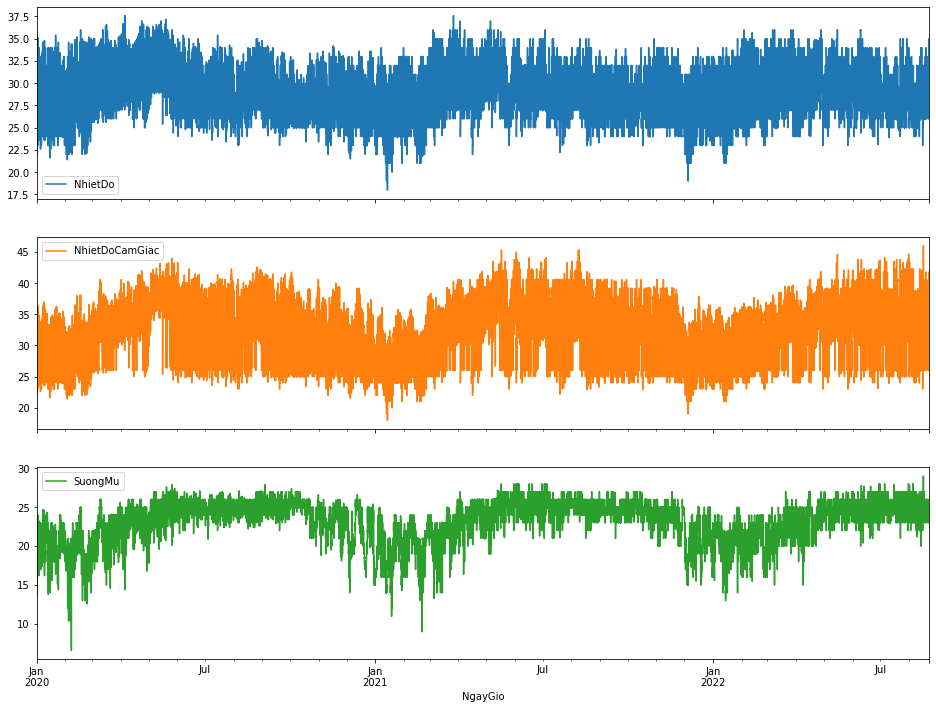

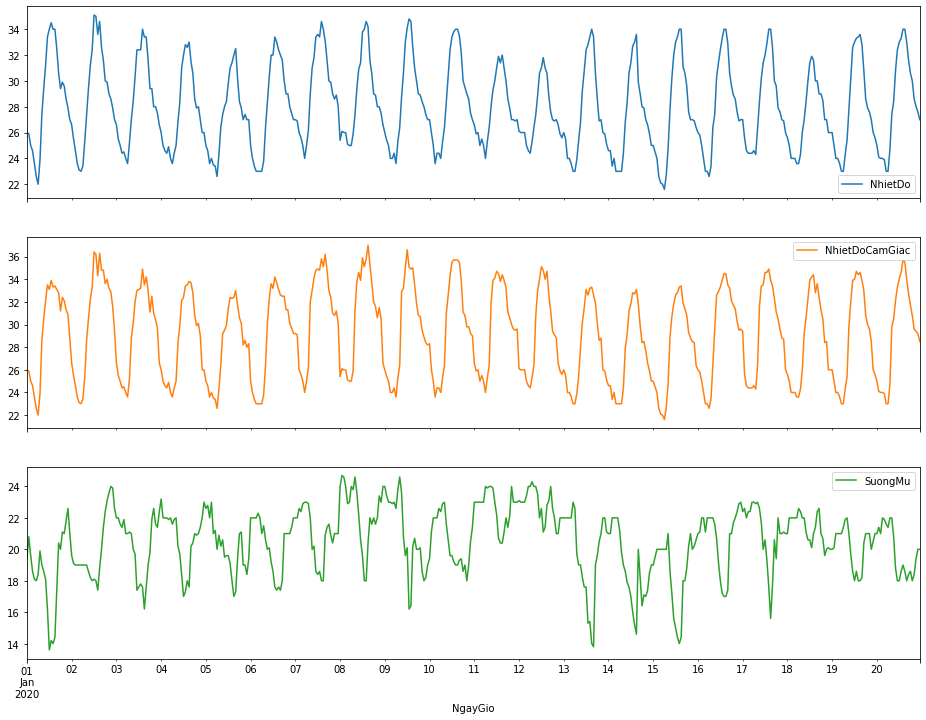

In [ ]:
plot_cols = ['NhietDo', 'NhietDoCamGiac', 'SuongMu']

# Tất cả mẫu
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# 480 mẫu đầu
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Kiểm tra và làm sạch dữ liệu

Thống kê bộ dữ liệu:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NhietDo,23160.0,28.374758,2.938523,18.0,26.00,28.00,30.40,37.6
NhietDoCamGiac,23160.0,31.377470,5.043544,18.0,26.00,31.40,35.30,46.0
SuongMu,23160.0,23.266952,2.628022,6.6,22.00,24.00,25.00,29.0
DoAm,23160.0,75.964521,16.544767,17.9,64.26,78.92,88.84,100.0
Mua,23160.0,0.222984,2.381544,0.0,0.00,0.00,0.00,85.0
XacSuatMua,23160.0,12.297064,32.841059,0.0,0.00,0.00,0.00,100.0
TocDoGio,23160.0,9.446472,5.416792,0.0,5.40,9.20,13.00,50.0
HuongGio,23160.0,182.675872,93.857122,0.0,120.00,180.00,255.00,360.0
ApSuat,16280.0,1008.902451,2.411782,1001.0,1007.00,1009.00,1010.40,1018.1
MayBaoPhu,23160.0,55.307694,22.003980,0.0,46.30,50.00,72.60,100.0


Thông tin bộ dữ liệu:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23160 entries, 0 to 23159
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NhietDo         23160 non-null  float64
 1   NhietDoCamGiac  23160 non-null  float64
 2   SuongMu         23160 non-null  float64
 3   DoAm            23160 non-null  float64
 4   Mua             23160 non-null  float64
 5   XacSuatMua      23160 non-null  int64  
 6   TrangThaiMua    3312 non-null   object 
 7   TocDoGio        23160 non-null  float64
 8   HuongGio        23160 non-null  float64
 9   ApSuat          16280 non-null  float64
 10  MayBaoPhu       23160 non-null  float64
 11  TamNhin         23139 non-null  float64
 12  ChiSoUV         23134 non-null  float64
 13  KetLuan         23160 non-null  object 
dtypes: float64(11), int64(1), object(2)
memory usage: 2.5+ MB


Bổ sung dữ liệu thiếu (Cho bằng giá trị trung bình)

In [ ]:
for index, value in enumerate(df['ApSuat']):
  if value > 0:
    pass
  else:
    df['ApSuat'][index] = df['ApSuat'].mean()

for index, value in enumerate(df['TamNhin']):
  if value > 0:
    pass
  else:
    df['TamNhin'][index] = df['TamNhin'].mean()

for index, value in enumerate(df['ChiSoUV']):
  if value > 0:
    pass
  else:
    df['ChiSoUV'][index] = df['ChiSoUV'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Chuẩn hóa `XacSuatMua`(Tính toán nhanh hơn)

In [ ]:
df['XacSuatMua'] = df['XacSuatMua'] / 100

Mã hóa dữ liệu kiểu chuỗi

In [ ]:
le = preprocessing.LabelEncoder()
df['TrangThaiMua'] = le.fit_transform(df['TrangThaiMua'])
df['KetLuan'] = le.fit_transform(df['KetLuan'])

### Phân tích đặc trưng

Trước khi bắt đầu xây dựng mô hình, điều quan trọng là phải hiểu dữ liệu và đảm bảo rằng dữ liệu được định dạng phù hợp cho mô hình.

#### Gió
Cột `HuongGio` của dữ liệu có đơn bị là độ. Mô hình sẽ không học tốt với kiểu dữ liệu này. Nếu gió không thổi thì phương hướng không quan trọng.

Dữ liệu hiện tại có dạng như sau:

Text(0, 0.5, 'Tốc độ gió [m/s]')

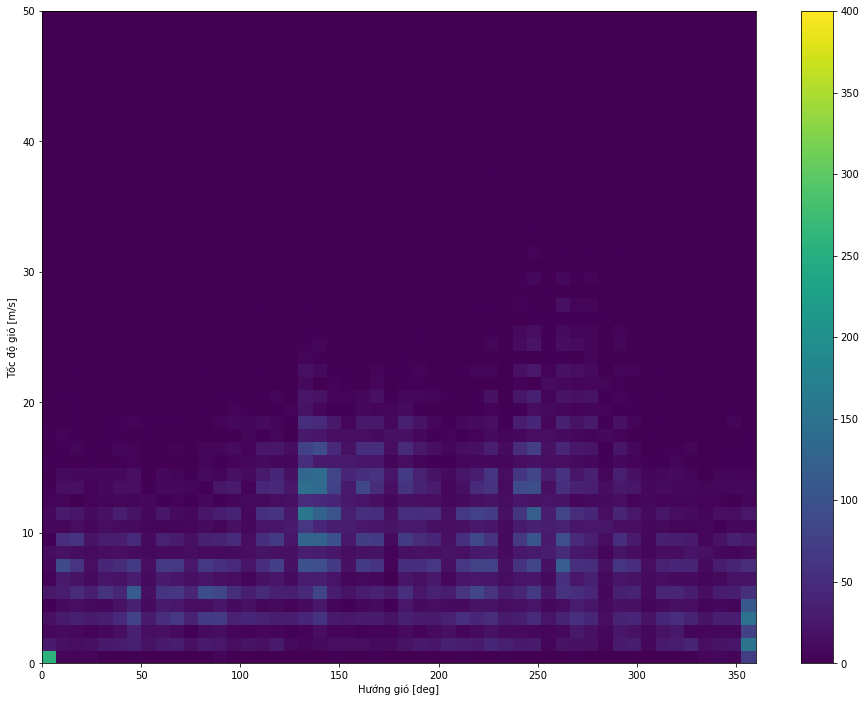

In [ ]:
plt.hist2d(df['HuongGio'], df['TocDoGio'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Hướng gió [deg]')
plt.ylabel('Tốc độ gió [m/s]')

Sẽ dễ dàng hơn cho mô hình nếu chuyển đổi các cột hướng gió và vận tốc thành **Vectơ** gió:

In [ ]:
wv = df.pop('TocDoGio')

# Chuyển đổi sang radian.
wd_rad = df.pop('HuongGio') * np.pi / 180

# Tính vectơ gió theo trục X và Y.
df['GioX'] = wv * np.cos(wd_rad)
df['GioY'] = wv * np.sin(wd_rad)

Sự phân bố của các vectơ gió đơn giản hơn nhiều để mô hình có thể hiểu một cách chính xác.

Dữ liệu sau khi chuyển đổi:

(-35.24723393402665,
 38.302222155948904,
 -40.081675547596866,
 32.13938048432696)

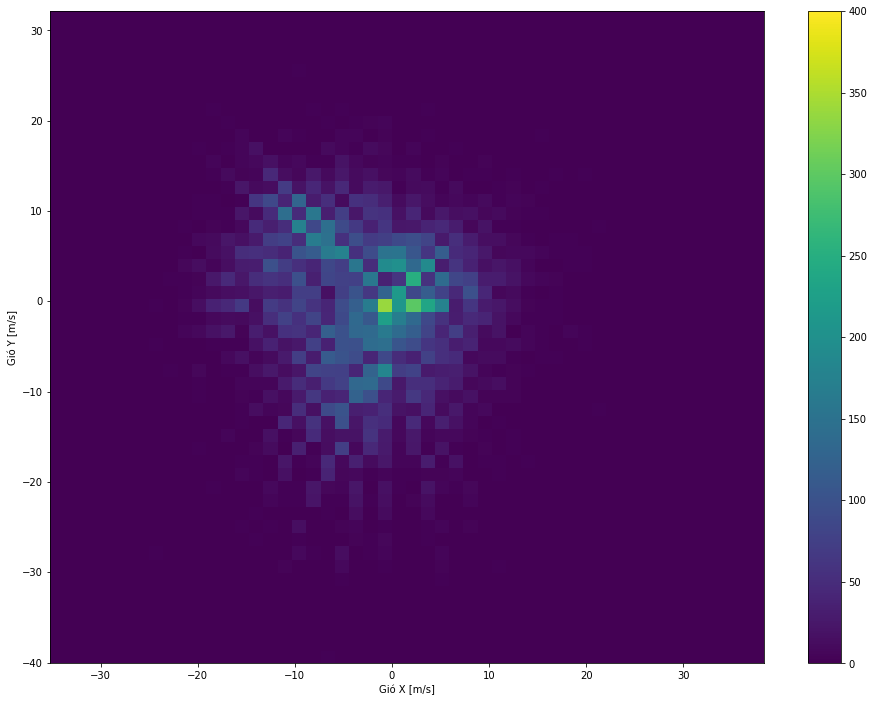

In [ ]:
plt.hist2d(df['GioX'], df['GioY'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Gió X [m/s]')
plt.ylabel('Gió Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Thời gian

Tương tự, `NgayGio` không nên để ở dạng chuỗi. Đầu tiên hãy chuyển nó thành giây:

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Tương tự như hướng gió, thời gian tính bằng giây không phải là đầu vào mô hình hữu ích. Dữ liệu thời tiết có tính định kỳ hàng ngày và hàng năm rõ ràng. Có nhiều cách có thể đối phó với tính chu kỳ.

Có thể sử dụng các phép biến đổi sin và côsin để xóa các tín hiệu "Thời gian trong ngày" và "Thời gian trong năm":

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['NgaySin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['NgayCos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['NamSin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['NamCos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Tín hiệu thời gian trong ngày')

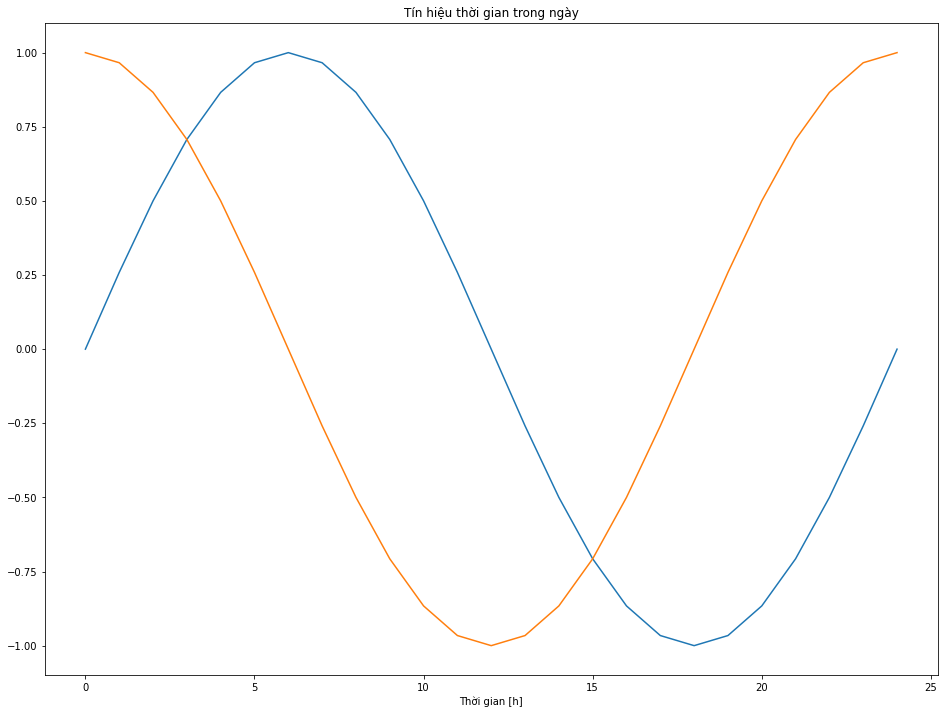

In [ ]:
plt.plot(np.array(df['NgaySin'])[:25])
plt.plot(np.array(df['NgayCos'])[:25])
plt.xlabel('Thời gian [h]')
plt.title('Tín hiệu thời gian trong ngày')

Điều này cho phép mô hình truy cập vào các tính năng tần số quan trọng nhất.

Để kiểm tra các giả định, đây là **tf.signal.rfft** của nhiệt độ theo thời gian. Lưu ý các đỉnh rõ ràng ở tần suất gần **1/year** và **1/day**:


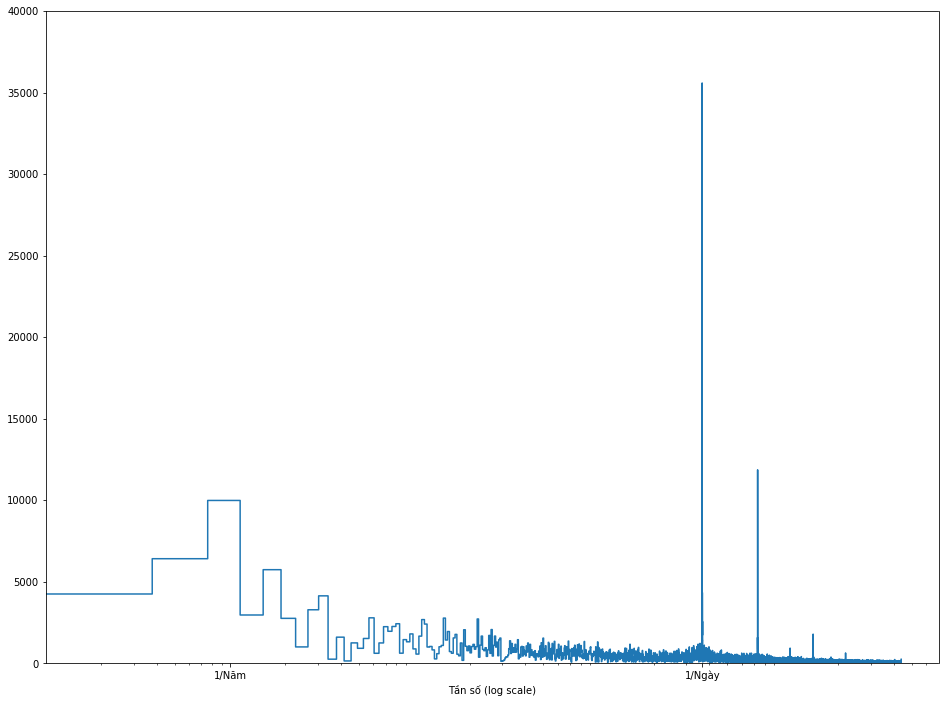

In [ ]:
fft = tf.signal.rfft(df['NhietDo'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['NhietDo'])
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / (hours_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Năm', '1/Ngày'])
_ = plt.xlabel('Tần số (log scale)')

### Chia dữ liệu

Dữ liệu sẽ được chia thành **(70%, 20%, 10%)** cho các tập **huấn luyện**, **tối ưu** và **kiểm nghiệm**. Lưu ý dữ liệu **không** được xáo trộn ngẫu nhiên trước khi tách. Vì:

1. Nó đảm bảo rằng việc cắt dữ liệu thành các cửa sổ của các mẫu liên tiếp vẫn có thể thực hiện được.
2. Nó đảm bảo rằng kết quả xác nhận / kiểm tra thực tế hơn, được đánh giá dựa trên dữ liệu thu thập được sau khi mô hình được đào tạo.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Chuẩn hóa dữ liệu

Điều quan trọng là phải **scale** các đặc trưng trước khi đào tạo mạng nơ-ron. Chuẩn hóa là một cách phổ biến để thực hiện việc chia tỷ lệ này: **trừ giá trị trung bình và chia cho độ lệch chuẩn của mỗi đặc trưng**.

Giá trị trung bình và độ lệch chuẩn chỉ nên được tính bằng cách sử dụng dữ liệu **huấn luyện** để mô hình không truy cập vào các giá trị trong bộ **tối ưu** và **kiểm nghiệm**.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Sự phân bố của các dữ liệu

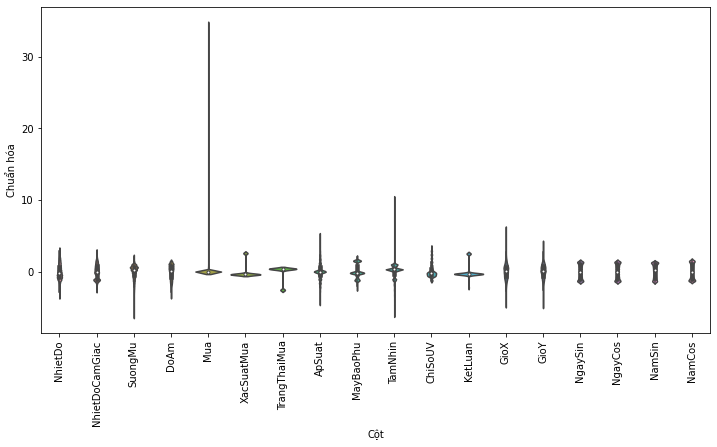

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Cột', value_name='Chuẩn hóa')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Cột', y='Chuẩn hóa', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing (Cửa sổ dữ liệu)

Đầu ra của các mô hình sẽ tạo ra **một tập hợp các dự đoán** dựa trên các **đầu vào liên tục** từ dữ liệu

Các đặc trưng chính:

- Chiều rộng (Số khoảng thời gian) của đầu vào và nhãn.
- Khoảng cách thời gian.
- Những đặc trưng nào được sử dụng làm đầu vào, nhãn hoặc cả hai.

Xây dựng trên nhiều mô hình khác nhau (bao gồm mô hình Tuyến tính, DNN, CNN và RNN) và sử dụng chúng cho cả hai:

- Dự đoán *Single-output (một đầu ra)* và *multi-output (nhiều đầu ra)*.
- Dự đoán *Single-time-step (một bước thời gian)* and *multi-time-step (nhiều bước thời gian)* predictions.

Phần này tập trung vào việc triển khai cửa sổ dữ liệu để nó có thể được sử dụng lại cho tất cả các mô hình đó.

Tùy thuộc vào nhiệm vụ và loại mô hình, ta có thể muốn tạo nhiều cửa sổ dữ liệu khác nhau. Dưới đây là một số ví dụ:

1. Với 24 giờ trước, để đưa ra một dự đoán duy nhất trong 24 giờ tới ta có thể xác định một cửa sổ như sau:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. Với 6 giờ trước, để đưa ra một dự đoán duy nhất trong 1 giờ tới ta có thể xác định một cửa sổ như sau:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

Phần còn lại của phần này định nghĩa một lớp `WindowGenerator`. Lớp này có thể:

1. Xử lý các **indexes (chỉ số)** và **offsets (hiệu số)**.
1. chia cửa sổ của các đặc trưng thành các cặp `(features, labels)`.
2. Trục quan hóa nội dung.
3. Sử dụng thư viện `tf.data.Dataset` để tạo các **batch** cho các tập **huấn luyện**, **tối ưu** và **kiểm nghiệm**.

### 1. Chỉ số và hiệu số

Bằng cách tạo ra lớp `WindowGenerator`. Phương thức `__init__` bao gồm tất cả các logic cần thiết cho các chỉ số đầu vào và nhãn.

Nó cũng lấy việc đào tạo, đánh giá và kiểm tra **DataFrames (Khung dữ liệu)** làm đầu vào. Chúng sẽ được chuyển đổi thành `tf.data.Dataset` của windows sau này.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Thiết lập chỉ số nhãn.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Thiết lập tham số cửa sổ.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Tổng kích thước cửa sổ: {self.total_window_size}',
        f'Chỉ số đầu vào: {self.input_indices}',
        f'Chỉ số nhãn: {self.label_indices}',
        f'Tên cột: {self.label_columns}'])

Mã tạo 2 cửa sổ được hiển thị trong sơ đồ ở đầu phần:

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['NhietDo'])
w1

Tổng kích thước cửa sổ: 48
Chỉ số đầu vào: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Chỉ số nhãn: [47]
Tên cột: ['NhietDo']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['NhietDo'])
w2

Tổng kích thước cửa sổ: 7
Chỉ số đầu vào: [0 1 2 3 4 5]
Chỉ số nhãn: [6]
Tên cột: ['NhietDo']

### 2. Split (Tách)

Phương thức `split_window` sẽ chuyển đổi danh sách đầu vào liên tục thành một cửa sổ đầu vào và một của số dán nhãn.

Ví dụ `w2` được tách như sau:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

Biểu đồ này không hiển thị trục `đặc trưng` của dữ liệu nhưng phương thức `split_window` cũng giải quyết được `label_columns` để có thể sử dụng nó cho cả ví dụ đầu ra đơn và nhiều đầu ra.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Cắt lát không lưu giữ thông tin hình dạng tĩnh, vì vậy hãy đặt các hình dạng theo cách thủ công. Bằng cách này, việc kiểm tra `tf.data.Datasets` sẽ dễ dàng hơn.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Thử in ra màn hình:

In [ ]:
# Xếp chồng ba lát, tổng chiều dài của cửa sổ.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('Tất cả dạng gồm: (gói, thời gian, đặc trưng)')
print(f'Dạng cửa sổ: {example_window.shape}')
print(f'Dạng đầu vào: {example_inputs.shape}')
print(f'Dạng dán nhãn: {example_labels.shape}')

Tất cả dạng gồm: (gói, thời gian, đặc trưng)
Dạng cửa sổ: (3, 7, 18)
Dạng đầu vào: (3, 6, 18)
Dạng dán nhãn: (3, 1, 1)


Thông thường, dữ liệu trong TensorFlow được đóng gói thành các mảng trong đó chỉ mục ngoài cùng nằm trên các ví dụ (chiều "gói"). Các chỉ số ở giữa là (các) chiều "thời gian" hoặc "không gian" (chiều rộng, chiều cao). Các chỉ số trong cùng là các tính năng.

Đoạn mã trên lấy một loạt ba cửa sổ 7 bước thời gian với 18 tính năng ở mỗi bước thời gian. Nó chia chúng thành một loạt các đầu vào tính năng bước 18 lần 6 và nhãn tính năng bước 1 lần 1. Nhãn chỉ có một tính năng vì `WindowGenerator` được khởi tạo với `label_columns=['NhietDo']` . Trước tiên xây dựng các mô hình dự đoán các nhãn đầu ra đơn lẻ.

### 3. Plot (Biểu đồ)

phương thức biểu đồ giúp trực quan hóa về phương pháp tách cửa sổ:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='NhietDo', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [Định mức]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Đầu vào', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Nhãn', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Dự đoán', c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Thời gian [h]')

WindowGenerator.plot = plot

Biểu đồ này sắp xếp các đầu vào, nhãn và dự đoán (sau này) dựa trên thời gian mà mục đề cập đến:

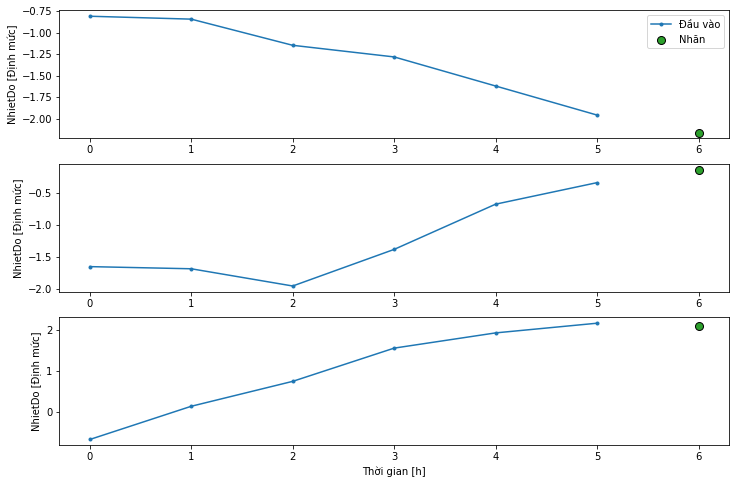

In [ ]:
w2.plot()

Bạn có thể vẽ biểu đồ cho các cột khác với cấu hình `w2`.

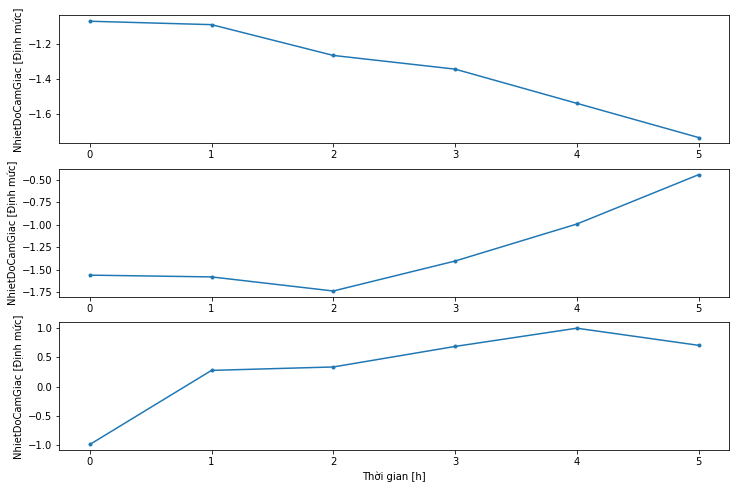

In [ ]:
w2.plot(plot_col='NhietDoCamGiac')

### 4. Tạo `tf.data.Dataset`

Phương thức `make_dataset` sử dụng một chuỗi thời gian **DataFrame** và chuyển đổi nó thành một `tf.data.Dataset` của các cặp `(input_window, label_window)` bằng cách sử dụng hàm `tf.keras.utils.timeseries_dataset_from_array`:

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

`WindowGenerator` chứa dữ liệu huấn luyện, xác thực và thử nghiệm.

Thêm các thuộc tính để truy cập chúng dưới dạng `tf.data.Dataset` bằng cách sử dụng phương thức `make_dataset` đã xác định trước đó.

Ngoài ra, thêm một lô ví dụ tiêu chuẩn để dễ dàng truy cập và vẽ biểu đồ:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Nhận và lưu vào bộ nhớ cache một loạt ví dụ `đầu vào, nhãn` để vẽ biểu đồ."""
  result = getattr(self, '_example', None)
  if result is None:
    # Không tìm thấy gói mẫu nên lấy một gói từ tập dữ liệu `.train`
    result = next(iter(self.train))
    # Lưu vào bộ nhớ cache cho lần sau
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Bây giờ đối tượng `WindowGenerator` cung cấp quyền truy cập vào các đối tượng `tf.data.Dataset` vì vậy có thể dễ dàng lặp lại dữ liệu.

Thuộc tính `Dataset.element_spec` cho biết cấu trúc, kiểu dữ liệu và hình dạng của các phần tử tập dữ liệu.

In [ ]:
# Mỗi phần tử là một cặp (đầu vào, nhãn).
w2.train.element_spec

(TensorSpec(shape=(None, 6, 18), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Lặp lại trên một `Dataset` sẽ tạo ra các gói cụ thể:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Dạng đầu vào (gói, thời gian, đặc trưng): {example_inputs.shape}')
  print(f'Dạng dán nhãn (gói, thời gian, đặc trưng): {example_labels.shape}')

Dạng đầu vào (gói, thời gian, đặc trưng): (32, 6, 18)
Dạng dán nhãn (gói, thời gian, đặc trưng): (32, 1, 1)


## Single step models (Mô hình một bước)

Mô hình đơn giản nhất mà bạn có thể xây dựng dựa trên loại dữ liệu này là mô hình dự đoán giá trị của một đối tượng địa lý — 1 bước thời gian (một giờ) trong tương lai chỉ dựa trên các điều kiện hiện tại.

Vì vậy, hãy bắt đầu bằng cách xây dựng các mô hình để dự đoán giá trị `NhietDo` trong một giờ tới trong tương lai.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Cấu hình đối tượng `WindowGenerator` để tạo các cặp `(input, label)` một bước:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['NhietDo'])
single_step_window

Tổng kích thước cửa sổ: 2
Chỉ số đầu vào: [0]
Chỉ số nhãn: [1]
Tên cột: ['NhietDo']

Đối tượng **window** tạo các `tf.data.Dataset` từ các tập huấn luyện, xác thực và kiểm tra, cho phép dễ dàng lặp lại các gói dữ liệu.


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Dạng đầu vào (gói, thời gian, đặc trưng): {example_inputs.shape}')
  print(f'Dạng dán nhãn (gói, thời gian, đặc trưng): {example_labels.shape}')

Dạng đầu vào (gói, thời gian, đặc trưng): (32, 1, 18)
Dạng dán nhãn (gói, thời gian, đặc trưng): (32, 1, 1)


### Baseline (Đường cơ sở)

Trước khi xây dựng một mô hình có thể đào tạo, tốt hơn là nên có một đường cơ sở hiệu suất làm điểm để so sánh với các mô hình phức tạp hơn sau này.

Nhiệm vụ đầu tiên là dự đoán nhiệt độ một giờ trong tương lai, với giá trị hiện tại của tất cả các đặc trưng. Các giá trị hiện tại bao gồm nhiệt độ hiện tại.

Vì vậy, hãy bắt đầu với một mô hình chỉ trả về nhiệt độ hiện tại như dự đoán, dự đoán là **"Không thay đổi"**. Đây là đường cơ sở hợp lý vì nhiệt độ thay đổi chậm. Tất nhiên, đường cơ sở này sẽ hoạt động kém hiệu quả hơn nếu đưa ra dự đoán xa hơn trong tương lai.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Khởi tạo và đánh giá mô hình:

In [ ]:
baseline = Baseline(label_index=column_indices['NhietDo'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

145/145 [==============================] - 1s 3ms/step - loss: 0.1503 - mean_absolute_error: 0.2668


Nó đã cho ta thấy một vài số liệu về hiệu suất nhưng nó không cho ta thấy được mô hình hoạt động tốt như thế nào.

`WindowGenerator` có thể tạo ra biểu đồ, tuy nhiên biểu đồ sẽ không có gì đáng kể nếu chỉ có một mẫu duy nhất.

Ta cần `WindowGenerator` rộng hơn để tạo ra các cửa sổ 24 giờ liên tiếp các đầu vào và nhãn tại một thời điểm. Biến `wide_window` mới không thay đổi cách hoạt động của mô hình. Mô hình vẫn đưa ra dự đoán một giờ trong tương lai dựa trên một bước thời gian đầu vào duy nhất. Ở đây, trục **time** hoạt động giống như trục **batch**: mỗi dự đoán được thực hiện độc lập mà không có sự tương tác giữa các bước thời gian:

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['NhietDo'])

wide_window

Tổng kích thước cửa sổ: 25
Chỉ số đầu vào: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Chỉ số nhãn: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Tên cột: ['NhietDo']

Cửa sổ mở rộng này có thể được chuyển trực tiếp đến cùng một mô hình `baseline` mà không có bất kỳ thay đổi mã nào. Điều này có thể thực hiện được vì các đầu vào và nhãn có cùng số bước thời gian và đường cơ sở chỉ chuyển tiếp đầu vào đến đầu ra:

![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [ ]:
print('Dạng đầu vào:', wide_window.example[0].shape)
print('Dạng đầu ra:', baseline(wide_window.example[0]).shape)

Dạng đầu vào: (32, 24, 18)
Dạng đầu ra: (32, 24, 1)


Bằng cách phác họa các dự đoán của mô hình cơ sở có thể thấy nó chỉ đơn giản là các nhãn dịch chuyển sang phải sau một giờ:

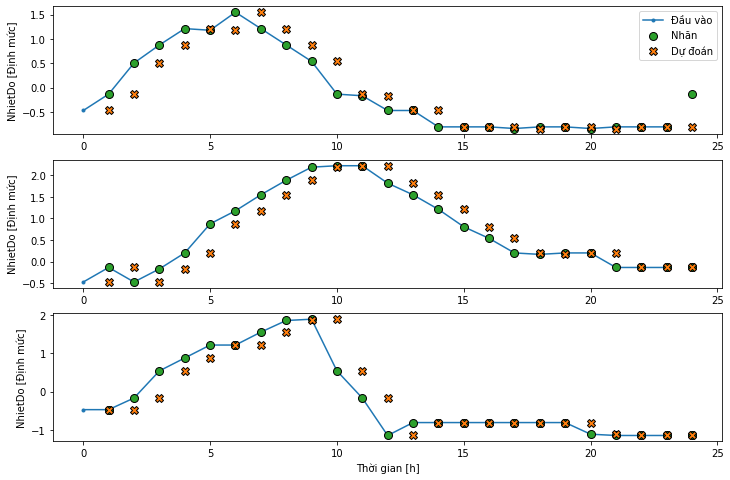

In [ ]:
wide_window.plot(baseline)

Trong ba ví dụ trên, mô hình một bước được chạy trong vòng 24 giờ:

- Dòng `Inputs` màu xanh lam hiển thị nhiệt độ đầu vào tại mỗi bước thời gian. Mô hình nhận được tất cả các **đặc trưng**.
- Các chấm `Labels` màu xanh lá cây hiển thị giá trị dự đoán mục tiêu. Các dấu chấm này được hiển thị tại thời điểm dự đoán không phải thời gian nhập liệu nên phạm vi nhãn luôn được dịch chuyển 1 bước so với đầu vào.
- Dấu gạch chéo `Predictions` màu cam là dự đoán của mô hình cho mỗi bước thời gian đầu ra. Nếu mô hình dự đoán hoàn hảo thì các dự đoán sẽ chồng lên các `Labels` .

### Linear model (Mô hình tuyến tính)

**Mô hình đào tạo** đơn giản nhất có thể áp dụng cho tác vụ này là chèn phép biến  đổi tuyến tính giữa đầu vào và đầu ra. Trong trường hợp này, kết quả từ một bước thời gian chỉ phụ thuộc vào bước đó:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Lớp `tf.keras.layers.Dense` có biến `activation` = 'None' là một mô hình tuyến tính. Lớp chỉ chuyển đổi trục cuối cùng của dữ liệu từ  `(batch, time, inputs)` thành `(batch, time, units)`; inó được áp dụng độc lập cho mọi mặt hàng trên các trục `batch` và `time`.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Dạng đầu vào:', single_step_window.example[0].shape)
print('Dạng đầu ra:', linear(single_step_window.example[0]).shape)

Dạng đầu vào: (32, 1, 18)
Dạng đầu ra: (32, 1, 1)


Ta sẽ đào tạo nhiều mô hình vì vậy hãy đóng gói quy trình đào tạo thành một hàm:

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train,
                      epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Đào tạo mô hình và đánh giá hiệu suất:

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
507/507 [==============================] - 3s 6ms/step - loss: 0.4086 - mean_absolute_error: 0.4721 - val_loss: 0.1590 - val_mean_absolute_error: 0.2963
Epoch 2/20
507/507 [==============================] - 3s 6ms/step - loss: 0.1369 - mean_absolute_error: 0.2660 - val_loss: 0.1232 - val_mean_absolute_error: 0.2539
Epoch 3/20
507/507 [==============================] - 3s 5ms/step - loss: 0.1124 - mean_absolute_error: 0.2333 - val_loss: 0.1174 - val_mean_absolute_error: 0.2487
Epoch 4/20
507/507 [==============================] - 5s 9ms/step - loss: 0.1048 - mean_absolute_error: 0.2230 - val_loss: 0.1142 - val_mean_absolute_error: 0.2459
Epoch 5/20
507/507 [==============================] - 3s 5ms/step - loss: 0.0999 - mean_absolute_error: 0.2166 - val_loss: 0.1109 - val_mean_absolute_error: 0.2421
Epoch 6/20
507/507 [==============================] - 3s 5ms/step - loss: 0.0962 - mean_absolute_error: 0.2119 - val_loss: 0.1086 - val_mean_absolute_error: 0.2395
Epoch 7/20
507/5

Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

Giống như mô hình `baseline`, mô hình tuyến tính có thể được gọi trên các gói `wide_window`. Mô hình tạo một tập hợp các dự đoán độc lập trên các bước thời gian liên tiếp. Trục `time` hoạt động giống như một trục `batch` khác. Không có tương tác giữa các dự đoán tại mỗi bước thời gian.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [ ]:
print('Dạng đầu vào:', wide_window.example[0].shape)
print('Dạng đầu ra:', baseline(wide_window.example[0]).shape)

Dạng đầu vào: (32, 24, 18)
Dạng đầu ra: (32, 24, 1)


Đây là sơ đồ các dự đoán trên `wide_window`. Nhiều trường hợp, dự đoán tốt hơn so với việc chỉ trả lại nhiệt độ đầu vào, nhưng trong một số trường hợp tệ hơn:

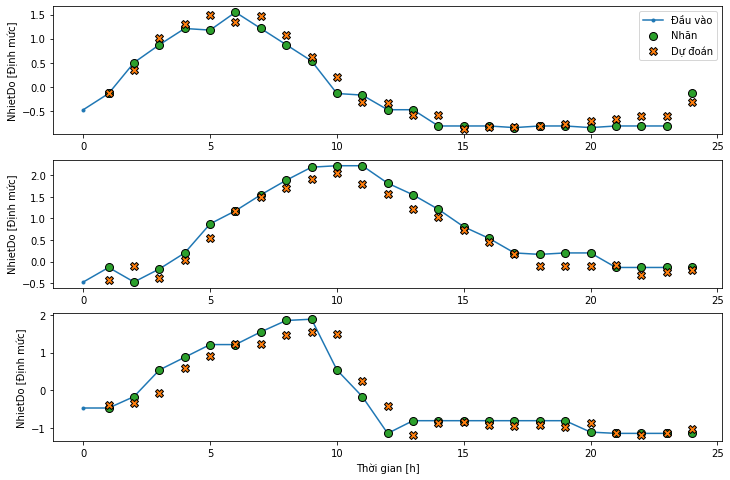

In [ ]:
wide_window.plot(linear)

Một lợi thế của các mô hình tuyến tính là chúng tương đối đơn giản để giải thích. Vó thể kéo trọng số của lớp ra và hình dung trọng lượng được chỉ định cho mỗi đầu vào:

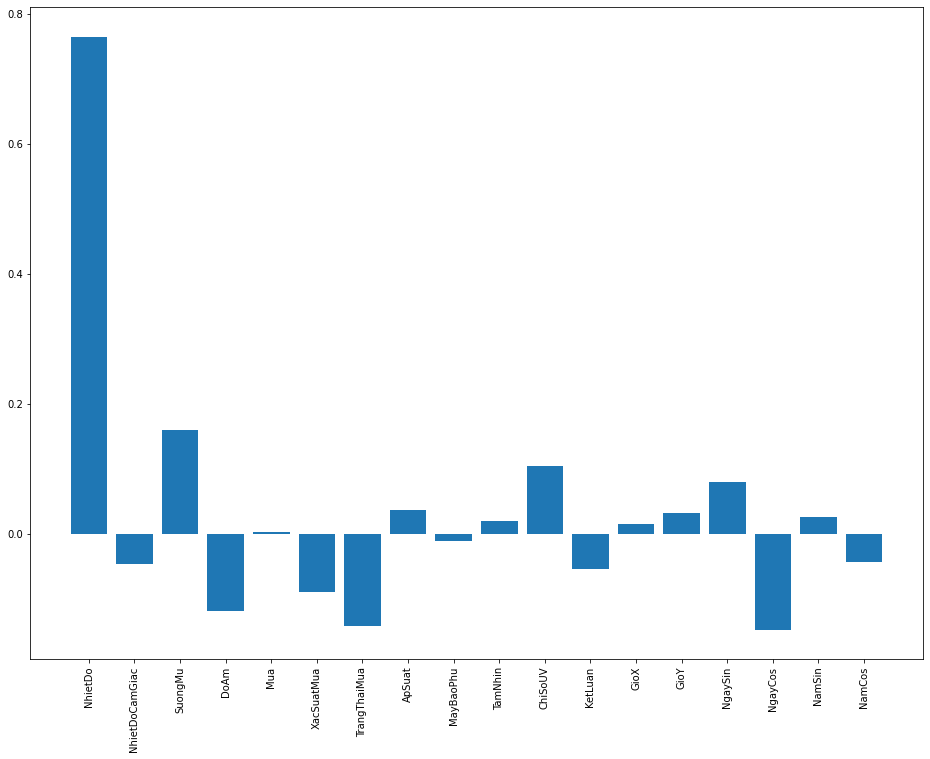

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Đôi khi mô hình thậm chí không đặt trọng lượng lớn nhất lên đầu vào `NhietDo` . Đây là một trong những rủi ro của việc khởi tạo ngẫu nhiên.

### Dense (dày đặc)

Trước khi áp dụng các mô hình thực sự hoạt động trên nhiều bước thời gian nên kiểm tra hiệu suất của các mô hình đơn đầu vào sâu hơn và mạnh mẽ hơn.

Đây là một mô hình tương tự như mô hình `linear`, nhưng xếp chồng một vài lớp `Dense` giữa đầu vào và đầu ra:

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
507/507 [==============================] - 4s 7ms/step - loss: 0.1231 - mean_absolute_error: 0.2382 - val_loss: 0.0875 - val_mean_absolute_error: 0.2141
Epoch 2/20
507/507 [==============================] - 3s 6ms/step - loss: 0.0801 - mean_absolute_error: 0.1923 - val_loss: 0.0882 - val_mean_absolute_error: 0.2143
Epoch 3/20
507/507 [==============================] - 3s 7ms/step - loss: 0.0773 - mean_absolute_error: 0.1875 - val_loss: 0.0853 - val_mean_absolute_error: 0.2092
Epoch 4/20
507/507 [==============================] - 3s 7ms/step - loss: 0.0753 - mean_absolute_error: 0.1846 - val_loss: 0.0823 - val_mean_absolute_error: 0.2026
Epoch 5/20
507/507 [==============================] - 3s 7ms/step - loss: 0.0737 - mean_absolute_error: 0.1819 - val_loss: 0.0861 - val_mean_absolute_error: 0.2101
Epoch 6/20
507/507 [==============================] - 3s 6ms/step - loss: 0.0726 - mean_absolute_error: 0.1808 - val_loss: 0.0813 - val_mean_absolute_error: 0.2001
Epoch 7/20
507/5

### Multi-step dense (Mô hình nhiều bước dày đặc)

Mô hình một bước thời gian không có ngữ cảnh cho các giá trị hiện tại của các đầu vào do không thể thấy các đặc trưng đầu vào thay đổi như thế nào theo thời gian. Để giải quyết vấn đề này, mô hình cần truy cập vào nhiều bước thời gian khi đưa ra dự đoán:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


Các mô hình `baseline`, `linear` và `dense` xử lý từng bước thời gian một cách độc lập. Ở đây mô hình sẽ thực hiện nhiều bước thời gian làm đầu vào để tạo ra một đầu ra duy nhất.

`WindowGenerator` sẽ tạo ra các gói đầu vào dài ba giờ và nhãn một giờ:

Lưu ý: Tham số `shift` của `Window` có liên quan đến phần cuối của hai cửa sổ.

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['NhietDo'])

conv_window

Tổng kích thước cửa sổ: 4
Chỉ số đầu vào: [0 1 2]
Chỉ số nhãn: [3]
Tên cột: ['NhietDo']

Text(0.5, 1.0, 'Nhập 3 giờ đầu vào, dự doán 1 giờ trong tương lai.')

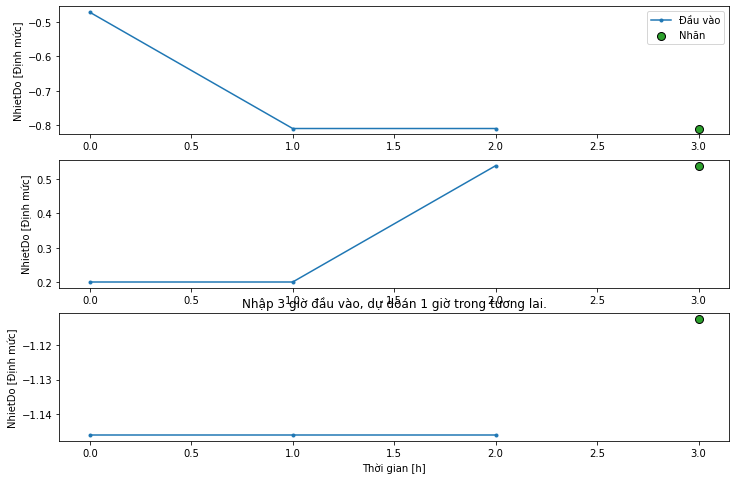

In [ ]:
conv_window.plot()
plt.title("Nhập 3 giờ đầu vào, dự doán 1 giờ trong tương lai.")

Có thể đào tạo một mô hình `dense` trên cửa sổ nhiều bước đầu vào bằng cách thêm `tf.keras.layers.Flatten` làm lớp đầu tiên của mô hình:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time * features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Dạng đầu vào:', conv_window.example[0].shape)
print('Dạng đầu ra:', multi_step_dense(conv_window.example[0]).shape)

Dạng đầu vào: (32, 3, 18)
Dạng đầu ra: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

145/145 [==============================] - 1s 4ms/step - loss: 0.0844 - mean_absolute_error: 0.2013


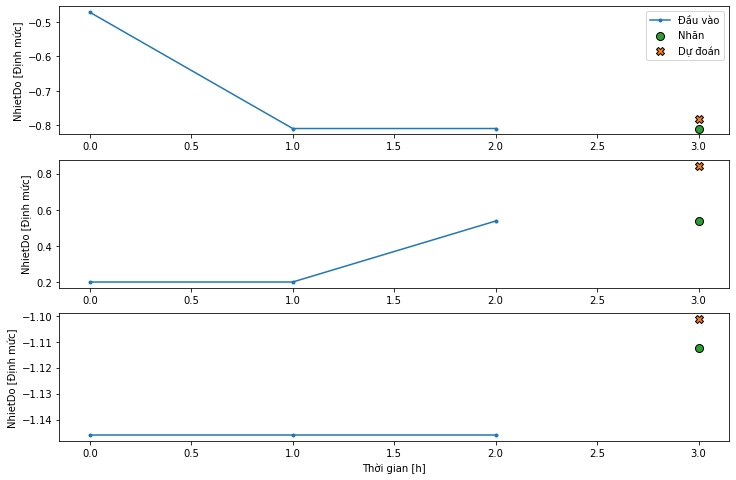

In [ ]:
conv_window.plot(multi_step_dense)

Nhược điểm chính của phương pháp này là mô hình kết quả chỉ có thể được thực thi trên các cửa sổ đầu vào có đúng **dạng** (như trên cmt).

In [ ]:
print('Dạng đầu vào:', wide_window.example[0].shape)
try:
  print('Dạng đầu ra:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Dạng đầu vào: (32, 24, 18)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 54, but received input with shape (32, 432)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 18), dtype=float32)
  • training=None
  • mask=None


Các mô hình tích chập trong phần tiếp theo sẽ khắc phục sự cố này.

### Convolution neural network (Mạng nơ-ron tích chập)
 
Một lớp tích chập (`tf.keras.layers.Conv1D`) cũng có nhiều bước thời gian làm đầu vào cho mỗi dự đoán.

đây là mô hình **tương tự** như `multi_step_dense` được viết lại bằng một tích chập.

Lưu ý:
* `tf.keras.layers.Flatten` và `tf.keras.layers.Dense` được thay thế bằng `tf.keras.layers.Conv1D`.
* `tf.keras.layers.Reshape` không còn cần thiết vì tích chập giữ trục thời gian trong đầu ra.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [ ]:
print("Mô hình tích chập `conv_window`")
print('Dạng đầu vào:', conv_window.example[0].shape)
print('Dạng đầu ra:', conv_model(conv_window.example[0]).shape)

Mô hình tích chập `conv_window`
Dạng đầu vào: (32, 3, 18)
Dạng đầu ra: (32, 1, 1)


Đào tạo và đánh giá trên ` conv_window` cung cấp hiệu suất tối giản cho mô hình `multi_step_dense`.

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

145/145 [==============================] - 1s 4ms/step - loss: 0.0811 - mean_absolute_error: 0.1979


Sự khác biệt giữa `conv_model` với mô hình `multi_step_dense` là `conv_model` có thể được chạy trên các đầu vào có độ dài bất kỳ. Lớp phức hợp được áp dụng cho một cửa sổ trượt của các đầu vào:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

Nếu chạy nó trên đầu vào rộng hơn, nó sẽ tạo ra đầu ra rộng hơn:

In [ ]:
print("Cửa sổ rộng")
print('Dạng đầu vào:', wide_window.example[0].shape)
print('Dạng nhãn:', wide_window.example[1].shape)
print('Dạng đầu ra:', conv_model(wide_window.example[0]).shape)

Cửa sổ rộng
Dạng đầu vào: (32, 24, 18)
Dạng nhãn: (32, 24, 1)
Dạng đầu ra: (32, 22, 1)


Lưu ý đầu ra ngắn hơn đầu vào.

Để cho việc đào tạo hoặc biểu đồ hoạt động cần đặt nhãn và dự đoán có cùng độ dài. Nên tạo `WindowGenerator` để tạo ra các `wide windows` với một vài bước thời gian nhập bổ sung để độ dài nhãn và dự đoán khớp với nhau:

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['NhietDo'])

wide_conv_window

Tổng kích thước cửa sổ: 27
Chỉ số đầu vào: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Chỉ số nhãn: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Tên cột: ['NhietDo']

In [ ]:
print("Cửa sổ rộng tích chập")
print('Dạng đầu vào:', wide_conv_window.example[0].shape)
print('Dạng nhãn:', wide_conv_window.example[1].shape)
print('Dạng đầu ra:', conv_model(wide_conv_window.example[0]).shape)

Cửa sổ rộng tích chập
Dạng đầu vào: (32, 26, 18)
Dạng nhãn: (32, 24, 1)
Dạng đầu ra: (32, 24, 1)


Có thể vẽ các dự đoán của mô hình trên một cửa sổ rộng hơn.

Lưu ý 3 bước thời gian nhập liệu trước lần dự đoán đầu tiên. Mọi dự đoán ở đây đều dựa trên 3 bước thời gian trước đó:

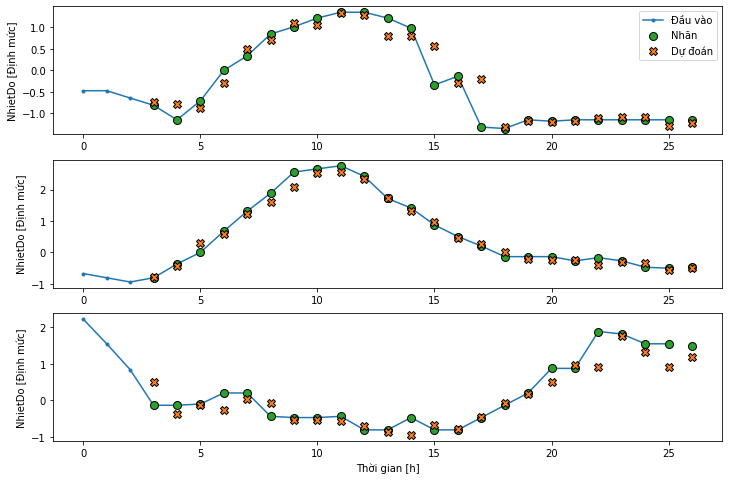

In [ ]:
wide_conv_window.plot(conv_model)

### Recurrent neural network (Mạng nơ-ron hồi quy)

Mạng nơ-ron hồi quy (RNN) à một loại mạng nơ-ron rất phù hợp với dữ liệu chuỗi thời gian. RNN xử lý chuỗi thời gian từng bước, duy trì trạng thái bên trong từ bước thời gian này sang bước thời gian khác.

sử dụng một lớp RNN có tên là **Long Short-Term Memory (Bộ nhớ ngắn hạn dài)**:  `tf.keras.layers.LSTM`.

Đối số phương thức khởi tạo quan trọng cho tất cả các lớp Keras RNN, chẳng hạn như `tf.keras.layers.LSTM` là đối số `return_sequences`. Có thể định cấu hình lớp theo một trong hai cách:

1. Nếu là `False` - mặc định, lớp chỉ trả về kết quả của bước thời gian cuối cùng, cho phép mô hình có thời gian để làm ấm trạng thái bên trong của nó trước khi đưa ra một dự đoán duy nhất:

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. Nếu là `True` lớp trả về một đầu ra cho mỗi đầu vào. Điều này hữu ích cho việc:
  * Xếp chồng các lớp RNN. 
  * Đào tạo một mô hình trên nhiều bước thời gian đồng thời.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

Với `return_sequences=True`, mô hình có thể được đào tạo dựa trên dữ liệu 24 giờ tại một thời điểm.

Lưu ý: Điều này sẽ cung cấp một cái nhìn bi quan về hiệu suất của mô hình. Ở bước thời gian đầu tiên, mô hình không có quyền truy cập vào các bước trước đó và do đó, không thể làm tốt hơn các mô hình `linear` và `dense` đơn giản được hiển thị trước đó.

In [ ]:
print('Dạng đầu vào:', wide_window.example[0].shape)
print('Dạng đầu ra:', lstm_model(wide_window.example[0]).shape)

Dạng đầu vào: (32, 24, 18)
Dạng đầu ra: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

145/145 [==============================] - 1s 5ms/step - loss: 0.0784 - mean_absolute_error: 0.1970


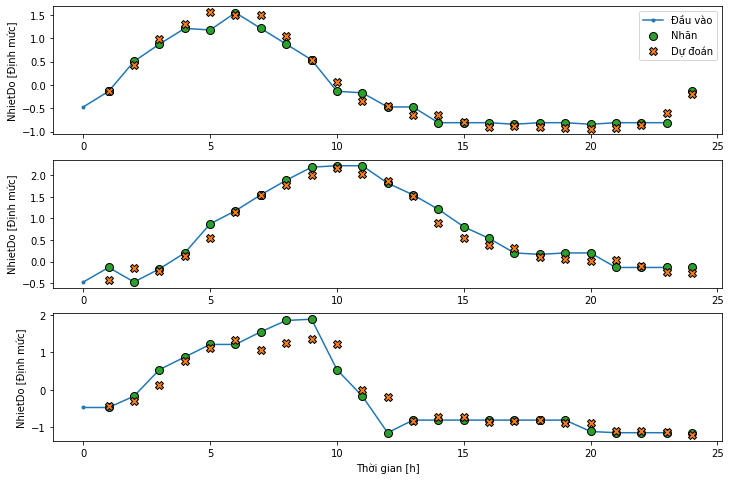

In [ ]:
wide_window.plot(lstm_model)

### Performance (Hiệu suất)

Với tập dữ liệu này, mỗi mô hình thường hoạt động tốt hơn một chút so với tập dữ liệu trước đó:

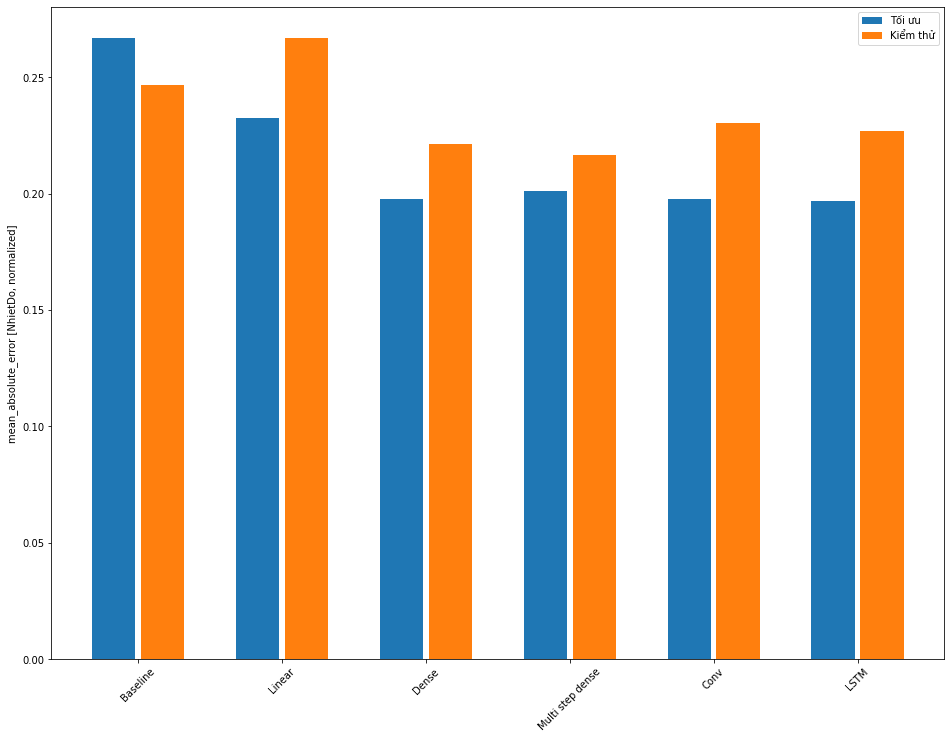

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [NhietDo, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Tối ưu')
plt.bar(x + 0.17, test_mae, width, label='Kiểm thử')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.2468
Linear      : 0.2669
Dense       : 0.2212
Multi step dense: 0.2167
Conv        : 0.2306
LSTM        : 0.2267


### Multi-output models (Các mô hình nhiều đầu ra)

Các mô hình trên đều dự đoán một đặc trưng đầu ra duy nhất là `NhietDo` cho một bước thời gian duy nhất.

Tất cả mô hình trên có thể chuyển đổi để dự đoán nhiều đặc trưng bằng cách thay đổi số lượng đơn vị trong lớp đầu ra và điều chỉnh cửa sổ đào tạo để bao gồm tất cả các đặc trưng trong `labels` (`example_labels`):

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Dạng đầu ra (gói, thời gian, đặc trưng): {example_inputs.shape}')
  print(f'Dạng đầu vào (gói, thời gian, đặc trưng): {example_labels.shape}')

Dạng đầu ra (gói, thời gian, đặc trưng): (32, 24, 18)
Dạng đầu vào (gói, thời gian, đặc trưng): (32, 24, 18)


Lưu ý: Trục `đặc trưng` của các nhãn hiện có cùng độ sâu với các đầu vào thay vì = **1**.

#### Đường cơ sở

Có thể sử dụng cùng một mô hình đường cơ sở (`Baseline`) nhưng lặp lại tất cả các tính năng thay vì chọn một `label_index` cụ thể:

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

145/145 [==============================] - 1s 4ms/step - loss: 0.3669 - mean_absolute_error: 0.2809


#### Dày đặc

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

145/145 [==============================] - 1s 5ms/step - loss: 0.3065 - mean_absolute_error: 0.3035


#### RNN


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

145/145 [==============================] - 1s 5ms/step - loss: 0.2416 - mean_absolute_error: 0.2779

CPU times: user 49 s, sys: 7.35 s, total: 56.4 s
Wall time: 42.9 s


#### Nâng cao: Residual connections (Kết nối dư)

Mô hình `Baseline` trước đó đã tận dụng lợi thế trình tự không thay đổi đáng kể theo từng bước thời gian. các mô hình trên đều được khởi tạo ngẫu nhiên và kết quả đầu ra là một thay đổi nhỏ so với bước thời gian trước đó.

Mặc dù có thể giải quyết vấn đề này bằng cách khởi tạo cẩn thận nhưng việc xây dựng điều này vào cấu trúc mô hình sẽ đơn giản hơn.

Thông thường trong phân tích chuỗi thời gian để xây dựng các mô hình thay vì dự đoán giá trị tiếp theo, hãy dự đoán giá trị sẽ thay đổi như thế nào trong bước thời gian tiếp theo. Tương tự, các mạng dư — hoặc ResNets — trong học sâu đề cập đến các kiến ​​trúc trong đó mỗi lớp thêm vào kết quả tích lũy của mô hình.

Đó là cách tận dụng kiến ​​thức rằng chỉ nên thay đổi một chút.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Về cơ bản, điều này khởi tạo mô hình để phù hợp với `Baseline`. Đối với nhiệm vụ này nó giúp các mô hình hội tụ nhanh hơn với hiệu suất tốt hơn một chút.

Cách tiếp cận này có thể được sử dụng kết hợp với bất kỳ mô hình nào ở trên.

Ở đây, nó đang được áp dụng cho mô hình LSTM. Lưu ý: việc sử dụng `tf.initializers.zeros` để đảm bảo rằng các thay đổi được dự đoán ban đầu là nhỏ và không ảnh hưởng kết nối còn lại. Không phá vỡ đối xứng với các **gradient** ở đây vì các `zeros` chỉ được sử dụng trên lớp cuối cùng.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # Dự đoán cho mỗi bước thời gian là đầu vào từ bước thời gian trước đó cộng với delta được mô hình tính toán.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # Các delta được dự đoán sẽ bắt đầu nhỏ.
        # Do đó, khởi tạo lớp đầu ra bằng  zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

145/145 [==============================] - 1s 5ms/step - loss: 0.2352 - mean_absolute_error: 0.2578

CPU times: user 38.1 s, sys: 5.72 s, total: 43.8 s
Wall time: 31.9 s


#### Hiệu suất

Hiệu suất tổng thể cho các mô hình đa đầu ra.

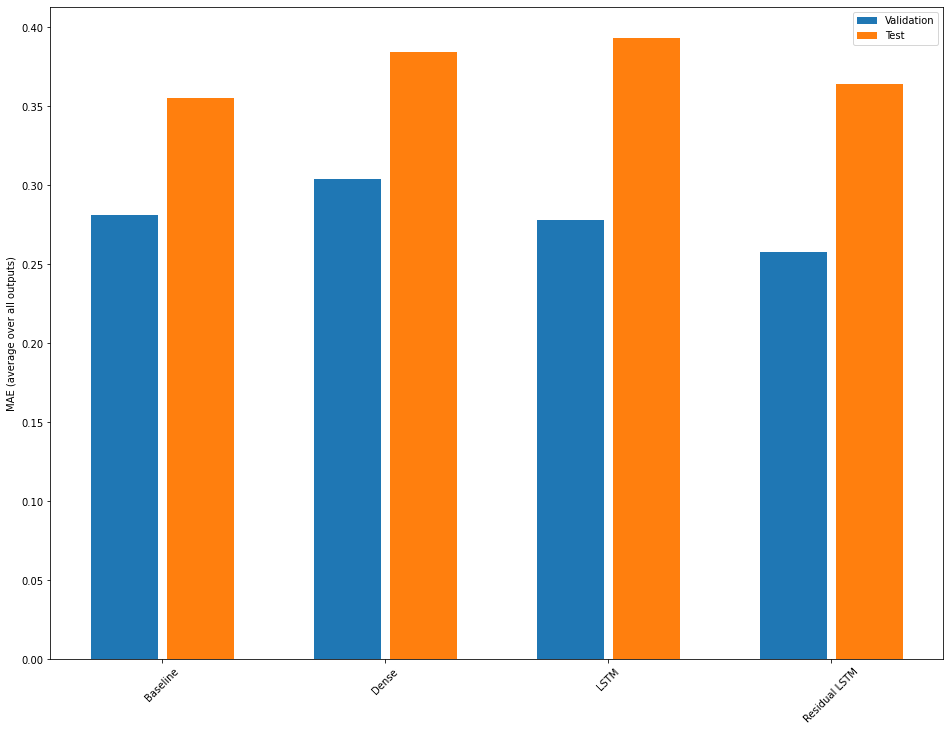

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.3549
Dense          : 0.3843
LSTM           : 0.3933
Residual LSTM  : 0.3639


Các hiệu suất trên được tính trung bình trên tất cả các đầu ra của mô hình.

## Multi-step models (Mô hình nhiều bước)

Cả mô hình một đầu ra và nhiều đầu ra trong các phần trước đều đưa ra các **dự đoán về bước thời gian duy nhất**, một giờ nữa trong tương lai.

Phần này xem xét cách mở rộng các mô hình này để đưa ra **dự đoán nhiều bước thời gian**.

Trong dự đoán nhiều bước mô hình cần học cách dự đoán một loạt các giá trị trong tương lai. Do đó không giống như mô hình một bước - chỉ dự đoán một điểm duy nhất trong tương lai. Mô hình nhiều bước dự đoán một chuỗi các giá trị trong tương lai.

Có hai cách tiếp cận cơ bản để giải quyết vấn đề này:

1. Dự đoán một lần chụp trong đó toàn bộ chuỗi thời gian được dự đoán cùng một lúc.
2. Dự đoán tự động hồi phục trong đó mô hình chỉ đưa ra dự đoán từng bước và đầu ra của nó được đưa trở lại làm đầu vào của nó.

Trong phần này, tất cả các mô hình sẽ dự đoán **tất cả các tính năng trên tất cả các bước thời gian đầu ra**.




Đối với mô hình nhiều bước, dữ liệu đào tạo lại bao gồm các mẫu hàng giờ.

Các mô hình sẽ học cách dự đoán 24 giờ trong tương lai bằng 24 giờ trong quá khứ.

Đây là một đối tượng `Window` tạo ra các lát này từ tập dữ liệu:

Tổng kích thước cửa sổ: 48
Chỉ số đầu vào: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Chỉ số nhãn: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Tên cột: None

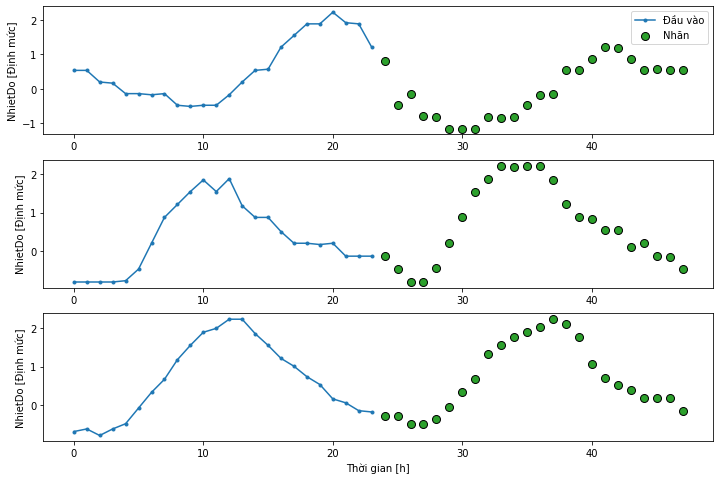

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Đường cơ sở

Một cơ sở đơn giản cho tác vụ này là lặp lại bước thời gian đầu vào cuối cùng cho số bước thời gian đầu ra được yêu cầu:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

144/144 [==============================] - 1s 4ms/step - loss: 1.1444 - mean_absolute_error: 0.6595


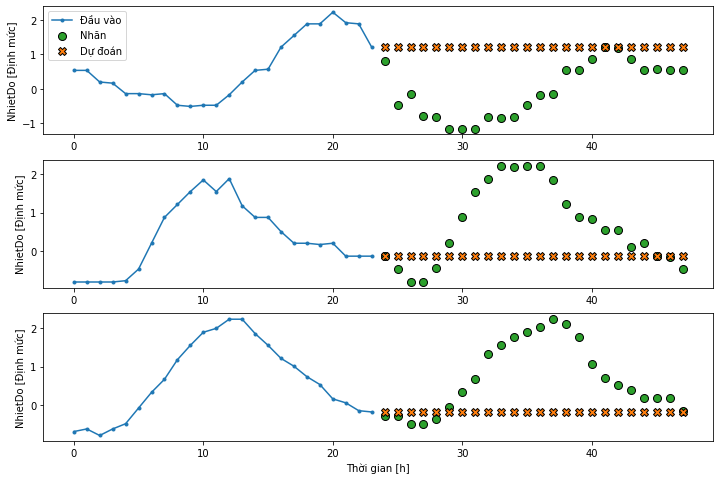

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Vì nhiệm vụ này là dự đoán 24 giờ trong tương lai bằng 24 giờ trong quá khứ nên có một cách tiếp cận đơn giản khác là lặp lại ngày trước đó, giả sử ngày mai sẽ tương tự:

![Repeat the previous day](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

144/144 [==============================] - 1s 4ms/step - loss: 0.5644 - mean_absolute_error: 0.3540


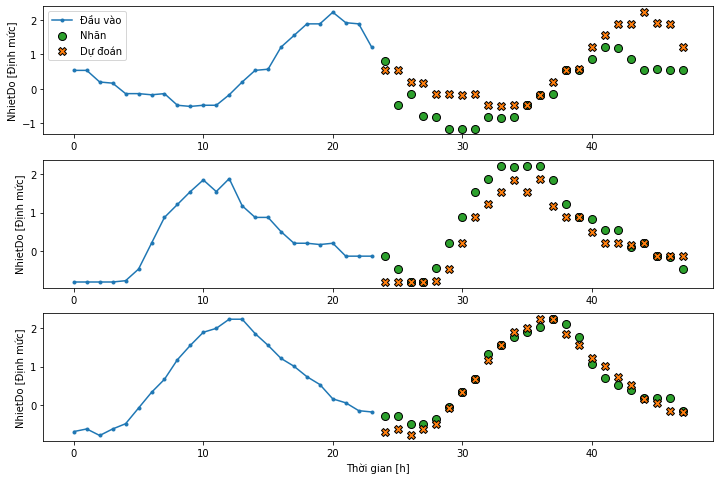

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models (Các kiểu chụp đơn)

Một cách tiếp cận cấp cao cho vấn đề này là sử dụng mô hình "một lần chụp", trong đó mô hình đưa ra dự đoán toàn bộ trình tự trong một bước duy nhất.

Điều này có thể được triển khai hiệu quả dưới dạng `tf.keras.layers.Dense` với các đơn vị đầu ra `OUT_STEPS*features`. Mô hình chỉ cần định hình lại đầu ra đó theo yêu cầu `(OUTPUT_STEPS, features)`.

#### Tuyến tính

Mô hình tuyến tính đơn giản dựa trên bước thời gian đầu vào cuối cùng hoạt động tốt hơn so với một trong hai mô hình cơ sở nhưng không đủ hiệu quả. Mô hình cần dự đoán các bước thời gian `OUTPUT_STEPS`, từ một bước thời gian đầu vào duy nhất với phép chiếu tuyến tính. Nó chỉ có thể ghi lại một phần hành vi có chiều hướng thấp, có thể chủ yếu dựa vào thời gian trong ngày và thời gian trong năm.

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

144/144 [==============================] - 1s 4ms/step - loss: 0.4200 - mean_absolute_error: 0.3799


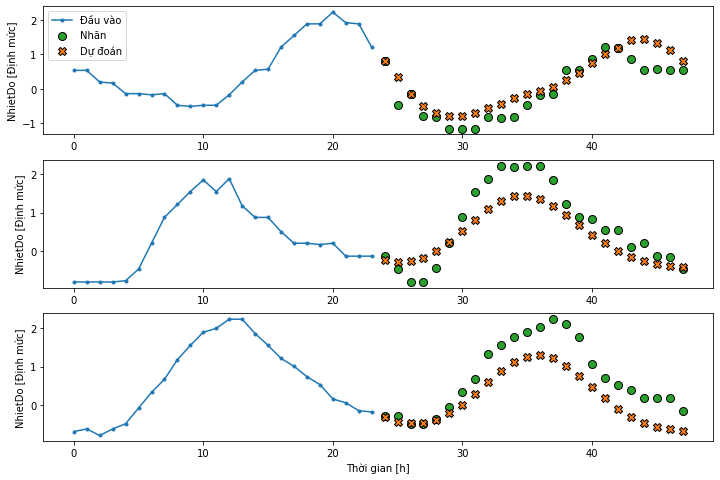

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dày đặc

Thêm `tf.keras.layers.Dense` giữa đầu vào và đầu ra mang lại cho mô hình tuyến tính hiệu quả hơn, nhưng vẫn chỉ dựa trên một bước thời gian đầu vào duy nhất.

144/144 [==============================] - 1s 5ms/step - loss: 0.3987 - mean_absolute_error: 0.3717


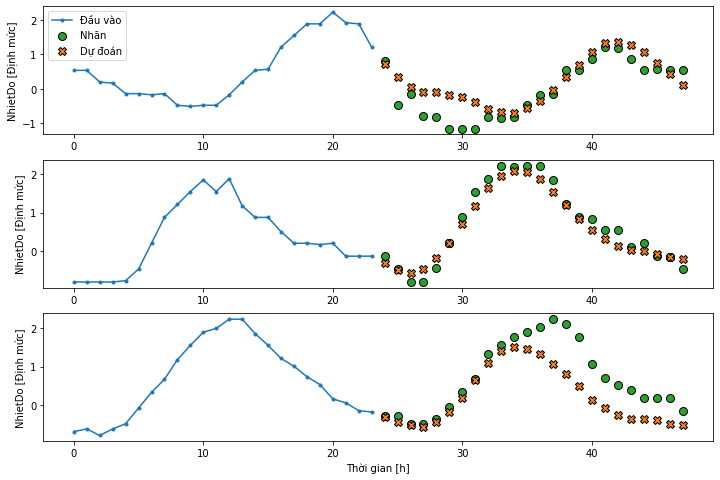

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Lấy bước thời gian cuối cùng.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

Mô hình tích hợp đưa ra các dự đoán dựa trên lịch sử có chiều rộng cố định, có thể dẫn đến hiệu suất tốt hơn so với mô hình dày đặc vì nó có thể thấy mọi thứ đang thay đổi như thế nào theo thời gian:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

144/144 [==============================] - 1s 4ms/step - loss: 0.3676 - mean_absolute_error: 0.3607


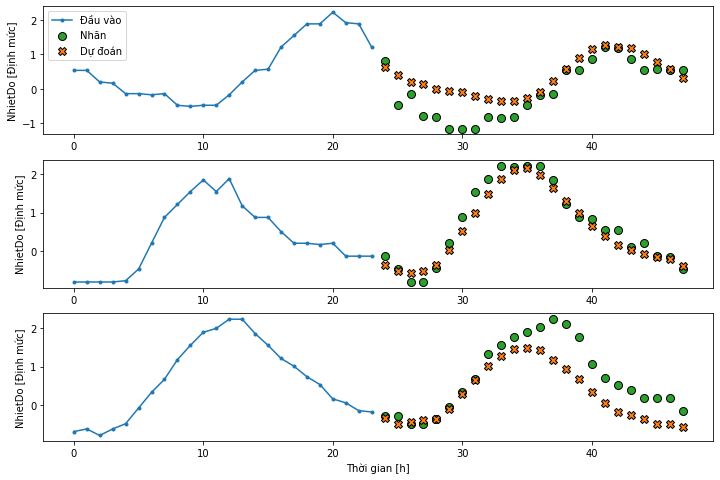

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

RNN có thể sử dụng lịch sử lâu dài từ các đầu vào nếu nó có liên quan đến các dự đoán mà mô hình đang đưa ra. Tại đây mô hình sẽ tích lũy trạng thái bên trong trong 24 giờ trước khi đưa ra một dự đoán duy nhất trong 24 giờ tiếp theo.

Ở định dạng chụp một lần này LSTM chỉ cần tạo ra một đầu ra ở bước thời gian cuối cùng nên đặt `return_sequences=False` trong `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


144/144 [==============================] - 1s 5ms/step - loss: 0.3774 - mean_absolute_error: 0.3800


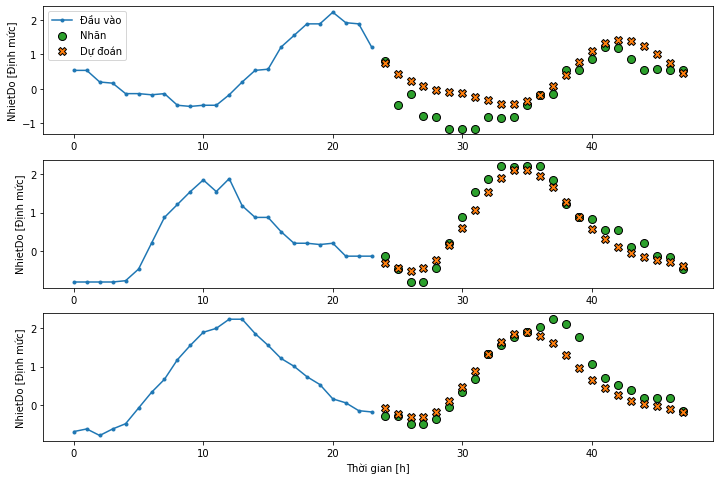

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Nâng cao: Autoregressive model (Mô hình tự động hồi quy)

Các mô hình trên đều dự đoán toàn bộ chuỗi đầu ra trong một bước duy nhất.

Trong một số trường hợp, mô hình có thể hữu ích khi phân tách dự đoán này thành các bước thời gian riêng lẻ. Sau đó, đầu ra của mỗi mô hình có thể được đưa trở lại chính nó ở mỗi bước và các dự đoán có thể được thực hiện với điều kiện trước đó

Một ưu điểm rõ ràng của kiểu mô hình này là nó có thể được thiết lập để tạo ra đầu ra với độ dài khác nhau.

Có thể thực hiện bất kỳ mô hình đa đầu ra đơn bước nào được đào tạo ở trên và chạy trong vòng phản hồi tự động hồi quy, nhưng hiện tại tập trung vào việc xây dựng một mô hình đã được đào tạo rõ ràng để làm điều đó.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

#### RNN

Hiện chỉ xây dựng mô hình RNN tự động hồi phục, nhưng mô hình này có thể được áp dụng cho bất kỳ mô hình nào được thiết kế để xuất ra một bước thời gian duy nhất.

Mô hình sẽ có dạng cơ bản giống như các mô hình LSTM một bước trước đó: một lớp `tf.keras.layers.LSTM` tiếp theo là một lớp `tf.keras.layers.Dense` chuyển đổi đầu ra của lớp `LSTM` thành các dự đoán của mô hình.

Một `tf.keras.layers.LSTM` là một `tf.keras.layers.LSTMCell` được bao bọc trong `tf.keras.layers.RNN` cấp cao hơn để quản lý trạng thái và kết quả trình tự

Trong trường hợp này, mô hình phải quản lý thủ công các đầu vào cho từng bước, vì vậy nó sử dụng `tf.keras.layers.LSTMCell` trực tiếp cho giao diện bước thời gian đơn, cấp thấp hơn.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

Phương pháp đầu tiên mà mô hình này cần`warmup` để khởi tạo trạng thái bên trong của nó dựa trên các đầu vào. Sau khi được đào tạo, trạng thái này sẽ nắm bắt các phần liên quan của lịch sử đầu vào. Điều này tương đương với mô hình `LSTM` một bước trước đó:

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

Phương thức này trả về một dự đoán bước thời gian duy nhất và trạng thái bên trong của `LSTM`:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 18])

Với trạng thái của `RNN` và dự đoán ban đầu, giờ đây có thể tiếp tục lặp lại mô hình cung cấp các dự đoán ở mỗi bước trở lại làm đầu vào.

Cách tiếp cận đơn giản nhất để thu thập các dự đoán đầu ra là sử dụng một danh sách Python và một `tf.stack` sau vòng lặp.

Lưu ý: Xếp chồng một danh sách Python như thế này chỉ hoạt động với `eager-execution`, dùng `Model.compile(..., run_eagerly=True)` để đào tạo hoặc với đầu ra có độ dài cố định. Đối với độ dài đầu ra động sử dụng `tf.TensorArray` thay vì danh sách Python và `tf.range` thay vì `range`.

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Chạy thử mô hình:

In [ ]:
print('Dạng đầu ra (gói, thời gian, đặc trưng): ', feedback_model(multi_window.example[0]).shape)

Dạng đầu ra (gói, thời gian, đặc trưng):  (32, 24, 18)


Đào tạo mô hình:

144/144 [==============================] - 2s 10ms/step - loss: 0.3981 - mean_absolute_error: 0.3951


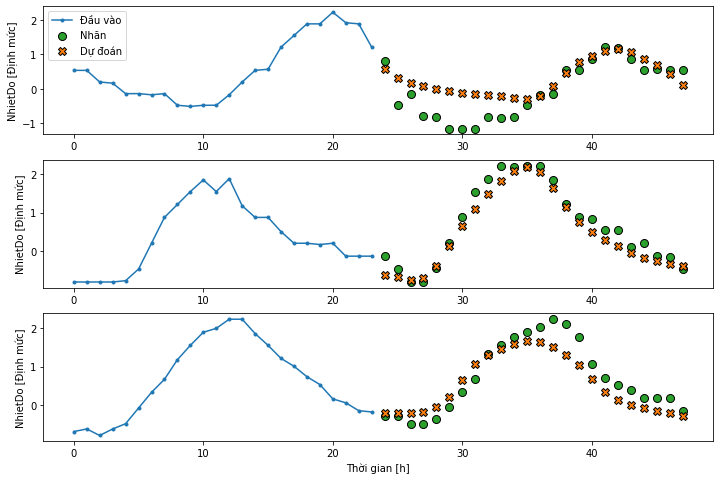

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Hiệu suất

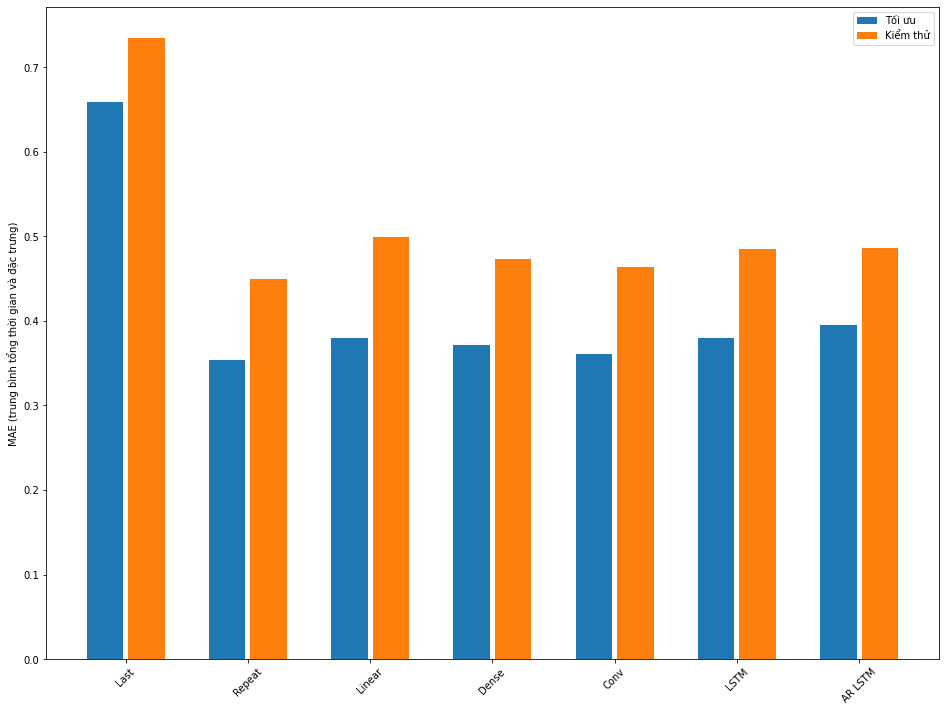

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Tối ưu')
plt.bar(x + 0.17, test_mae, width, label='Kiểm thử')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (trung bình tổng thời gian và đặc trưng)')
_ = plt.legend()

Các chỉ số cho các mô hình nhiều đầu ra cho thấy hiệu suất được tính trung bình trên tất cả các tính năng đầu ra. Các hiệu suất này tương tự nhưng cũng được tính trung bình qua các bước thời gian đầu ra.

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.7347
Repeat  : 0.4496
Linear  : 0.4989
Dense   : 0.4737
Conv    : 0.4641
LSTM    : 0.4848
AR LSTM : 0.4865


Lợi ích đạt được khi chuyển từ mô hình dày đặc sang mô hình tích hợp và hồi quy chỉ vài phần trăm (hoặc không). Còn với mô hình tự hồi quy hoạt động kém hơn rõ ràng. Vì vậy, những cách tiếp cận phức tạp hơn này có thể không có giá trị trong vấn đề này nhưng không có cách nào để biết nếu không thử và những mô hình này có thể hữu ích.

